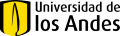

# Open Evaluation - Consultas Abiertas en Lenguaje Natural

## Descripción del Proyecto

Este notebook demuestra la capacidad del modelo entrenado para procesar **consultas abiertas** en lenguaje natural y generar órdenes de compra en formato JSON estructurado.

**Objetivo**: Validar que el modelo puede generalizar a textos no vistos durante el entrenamiento y generar JSONs válidos con estructura consistente según el esquema de la competencia.

**Contexto de negocio**: Una compañía de ventas recibe pedidos por múltiples canales (email, SMS, Markdown). Este modelo automatiza la conversión a un formato estándar JSON para procesamiento posterior.

---

## Integrantes Equipo 20
- Andrés Felipe Ñungo Fernández  
- Andrés Julián Gonzalez Barrera  
- Hernando Jose Jimenez Díaz  
- Gloria Inés López Urbano

---

## Requisitos del Proyecto

Este notebook es uno de los **4 entregables obligatorios** del proyecto final:

| # | Archivo | Descripción |
|---|---------|-------------|
| 1 | `train.ipynb` | Entrenamiento del modelo ||
| 2 | `weights.pt` | Pesos entrenados (generado por train)  |
| 3 | `evaluation.ipynb` | Evaluación en test set |  |
| 4 | **`open-evaluation.ipynb`** | **Este notebook** - Consultas abiertas  |

---

## Estructura del Notebook

1. **Configuración Inicial**: Librerías, dispositivo, y parámetros
2. **Carga del Modelo**: Tokenizer + Modelo base + Adaptadores LoRA
3. **Función Principal**: `generar_orden_compra()`
4. **Ejemplos de Uso**: 4+ casos variados (básico, completo, incompleto, multiproducto)
5. **Consulta Interactiva**: Para probar tus propios textos
6. **Análisis de Resultados**: Verificación de estructura JSON
7. **Exportación**: Guardar resultados

---

## Esquema JSON Esperado

El modelo genera JSONs con la siguiente estructura:

```json
{
  "buyer": {
    "name": "string",
    "email": "string",
    "contact": {"phone": "string", "preferred_contact": "email|phone|none"},
    "addresses": [{"street": "...", "city": "...", "country": "..."}]
  },
  "purchases": [
    {"product_name": "string", "quantity": integer, "currency": "USD|EUR|GBP"}
  ],
  "shipping": {
    "method": "standard|express|pickup",
    "preferred_by": "datetime"
  }
}
```


---

# 1. Configuración Inicial

Esta sección prepara el entorno de ejecución:
- **Librerías**: torch, transformers, PEFT para inferencia
- **Dispositivo**: Detección automática de CUDA/CPU
- **Semillas**: Reproducibilidad de resultados
- **Parámetros**: Configuración del modelo y generación

**Nota**: Este notebook requiere que `train.ipynb` haya sido ejecutado previamente para generar el modelo entrenado.


## 1.1 Importar Librerías

**Librerías principales:**
- `torch`: Framework de deep learning
- `transformers`: Modelos pre-entrenados (Qwen3-0.6B)
- `peft`: Parameter-Efficient Fine-Tuning (LoRA)
- `shared_functions`: Funciones personalizadas para construcción de prompts


In [ ]:
import os
import json
import random

import torch
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from peft import PeftModel
import shared_functions as custom_sharfun  # Funciones para construir prompts

# Configuración de warnings
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()


## 1.2 Configuración del Dispositivo y Semillas

**Configuración de reproducibilidad:**
- Semilla fija (42) para resultados consistentes
- Detección automática de GPU (CUDA) o CPU
- Configuración de semillas para torch, random y numpy


In [ ]:
# Configuración del dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)


## 1.3 Parámetros de Configuración

**Parámetros del modelo:**
- `MAX_LENGTH`: 1500 tokens (longitud máxima de entrada)
- `GEN_MAX_NEW_TOKENS`: 377 tokens (tokens máximos a generar)
- `MODEL_DIR`: Directorio con el modelo entrenado

**Batch size adaptativo:**
- GPU: 14 ejemplos por batch
- CPU: 8 ejemplos por batch (reduce memoria pero es más lento)

** Importante**: Verifica que el directorio del modelo exista antes de continuar.


In [ ]:
# IMPORTANTE: Configuración adaptada para modfinal_v04
# ------------------------------------------------------------------
# Evaluación
BATCH_SIZE_EVAL = 14 if DEVICE == "cuda" else 8  # Ajustado para CPU/GPU

# Data / tokenization
MAX_LENGTH = 1500
GEN_MAX_NEW_TOKENS = 377

# 🔧 MODELO: Usar modfinal_v04 (tu modelo entrenado)
MODEL_DIR = "modfinal_v04"
ADAPTER_DIR = MODEL_DIR
OUTPUT_DIR = "output/open_evaluation"  # Para guardar resultados de open evaluation

print(f" Modelo a usar: {ADAPTER_DIR}")
print(f" Verificando si existe...")
if os.path.exists(ADAPTER_DIR):
    print(f" Modelo encontrado en: {os.path.abspath(ADAPTER_DIR)}")
else:
    print(f" ERROR: No se encuentra {ADAPTER_DIR}")
    print(f"   Directorios disponibles:")
    for item in os.listdir("."):
        if os.path.isdir(item) and "mod" in item.lower():
            print(f"   - {item}")

# Crear directorio de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f" Directorio de salida: {OUTPUT_DIR}")


---

# 2. Carga del Modelo Entrenado

## 2.1 Proceso de Carga

El modelo se carga en 3 pasos:
1. **Tokenizer**: Configuración con `padding_side="left"` (importante para generación)
2. **Modelo base**: Qwen3-0.6B con o sin cuantización según dispositivo
3. **Adaptadores LoRA**: Pesos entrenados aplicados al modelo base

**Configuración según dispositivo:**
- **GPU (CUDA)**: Modelo cuantizado 4-bit → Reduce memoria ~60% con mínima pérdida de calidad
- **CPU**: Modelo en float32 → Sin cuantización (más lento pero funcional)

**Modo evaluación**: `model.eval()` desactiva dropout y pone BatchNorm en modo inferencia.

** Nota**: Respetar `tokenizer.padding_side = "left"` es crítico para que la generación funcione correctamente.


In [ ]:
print(f" Cargando tokenizer desde: {ADAPTER_DIR}")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR, local_files_only=True)
tokenizer.padding_side = "left"
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

MODEL_NAME = "Qwen/Qwen3-0.6B-Base"

if DEVICE == "cuda":
    print(" Cargando modelo base en 4 bits (GPU)...")
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto"
    )
else:
    print("  CPU detectado - Cargando modelo SIN cuantización (puede ser lento)...")
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float32,
        low_cpu_mem_usage=True
    )
    base_model = base_model.to(DEVICE)

print(f" Cargando adaptadores LoRA desde: {ADAPTER_DIR}")
model = PeftModel.from_pretrained(base_model, ADAPTER_DIR, local_files_only=True)
model.eval()
print(" Modelo cargado exitosamente en modo evaluación")


---

# 3. Open Evaluation - Consultas Abiertas

## 3.1 ¿Qué es Open Evaluation?

**Open Evaluation** permite probar el modelo con **textos completamente nuevos** que nunca vio durante el entrenamiento.

**Diferencias con evaluación estándar:**
- **Evaluación estándar**: Dataset fijo con respuestas conocidas → Mide F1 score
- **Open Evaluation**: Textos libres sin respuestas conocidas → Verifica generalización

**Casos de uso:**
- ✅ Probar pedidos reales de clientes
- ✅ Evaluar robustez ante textos mal escritos o incompletos
- ✅ Demostrar capacidades del modelo a stakeholders
- ✅ Detectar fallos en casos edge (datos faltantes, formatos raros)

---


## 3.2 Función Principal: `generar_orden_compra()`

Esta función es el punto de entrada para consultas abiertas:

**Entrada:**
- `texto_natural` (str): Pedido en lenguaje natural (email, SMS, etc.)
- `verbose` (bool): Si es True, muestra el JSON generado formateado

**Proceso interno:**
1. **Construcción del prompt**: Usa `custom_sharfun.build_prompt_text_to_json()`
2. **Tokenización**: Convierte texto → tokens (máx 1500)
3. **Generación**: Modelo produce tokens nuevos (máx 377)
4. **Extracción**: Busca y parsea el JSON en la respuesta
5. **Validación**: Verifica que sea JSON válido

**Salida:**
- `dict`: JSON parseado si exitoso
- `None`: Si no se pudo generar/parsear JSON

** Importante**: Esta función NO calcula F1 score porque no tiene "ground truth" para comparar.


In [ ]:
def generar_orden_compra(texto_natural: str, verbose: bool = True) -> dict:
    """
    Genera una orden de compra en formato JSON a partir de texto en lenguaje natural.
    
    Args:
        texto_natural: Texto en lenguaje natural describiendo la orden de compra
        verbose: Si True, imprime información adicional del proceso
    
    Returns:
        dict: JSON con la orden de compra estructurada
    """
    if verbose:
        print("\n" + "="*80)
        print(" TEXTO DE ENTRADA:")
        print("="*80)
        print(texto_natural)
        print("\n Generando JSON...\n")
    
    # Generar el JSON usando el modelo
    raw_output = generate_json_raw(
        text=texto_natural,
        max_new_tokens=GEN_MAX_NEW_TOKENS,
        max_length=MAX_LENGTH,
        tokenizer=tokenizer,
        model=model,
        device=DEVICE
    )
    
    # Extraer JSON del texto generado
    json_obj = extract_json_from_text(raw_output)
    
    if json_obj is None:
        if verbose:
            print(" No se pudo extraer un JSON válido")
            print("\n Salida cruda del modelo:")
            print(raw_output)
        return {}
    
    if verbose:
        print("="*80)
        print(" JSON GENERADO:")
        print("="*80)
        print(json.dumps(json_obj, indent=2, ensure_ascii=False))
        print("="*80)
    
    return json_obj


## 3.3 Ejemplos de Uso

### Ejemplo 1: Pedido Completo y Bien Estructurado

**Caso:** Cliente proporciona toda la información necesaria de forma clara.

**Expectativa:** El modelo debe extraer correctamente:
- Nombre y contacto del comprador
- Lista de productos con cantidades
- Dirección de envío completa
- Método de envío y fecha preferida


In [ ]:
texto_ejemplo_1 = """
Hola, necesito hacer un pedido urgente.

Mi nombre es María García y mi correo es maria.garcia@example.com
Mi teléfono es +34-555-123-456

Quiero comprar:
- 2 teclados inalámbricos
- 1 mouse ergonómico

Mi dirección es: Calle Mayor 123, Madrid, España, código postal 28013

Necesito envío express para antes del 15 de diciembre de 2025.

Gracias!
"""

resultado_1 = generar_orden_compra(texto_ejemplo_1)


### Ejemplo 2: Pedido con Información Incompleta

**Caso:** Cliente omite algunos detalles (sin email, sin teléfono, sin fecha).

**Expectativa:** El modelo debe:
- Extraer lo que está disponible
- Usar valores por defecto razonables para lo faltante
- Mantener la estructura JSON válida


### Ejemplo 3: Tu Propia Consulta

**Instrucciones:**
1. Modifica el texto en la celda siguiente
2. Ejecuta la celda para ver el JSON generado
3. Observa cómo el modelo interpreta tu texto

** Tips para mejores resultados:**
- Incluye nombre del comprador
- Especifica productos y cantidades claramente
- Menciona dirección de envío
- Indica método de envío si es importante


In [ ]:
#  Modifica el texto a continuación con tu propia orden de compra
mi_texto = """
Escribe aquí tu orden de compra en lenguaje natural...
"""

mi_resultado = generar_orden_compra(mi_texto)


---

## 3.4 Consulta Interactiva

**Modo interactivo**: Ejecuta esta celda para ingresar tu propia consulta desde el teclado.

**Casos de prueba sugeridos:**
- Pedido en lenguaje informal (como SMS)
- Pedido con errores de ortografía
- Pedido con múltiples productos
- Pedido internacional (diferentes países)
- Pedido urgente vs. envío estándar


In [ ]:
# Escribe tu consulta aquí y ejecuta la celda
consulta = input("Escribe tu orden de compra en lenguaje natural:\n")
resultado = generar_orden_compra(consulta)


---

## 3.5 Guardar Resultados

**Exportación de resultados**: Si necesitas guardar el JSON generado para su posterior uso.

**Formato de salida:**
- Archivo `.json` con indentación legible
- Codificación UTF-8 (soporta caracteres especiales)
- Nombre personalizable


In [ ]:
# Guardar el último resultado generado
output_file = "mi_orden_compra.json"

with open(output_file, "w", encoding="utf-8") as f:
    json.dump(resultado, f, indent=2, ensure_ascii=False)

print(f"Resultado guardado en: {output_file}")


---

##  Troubleshooting y Tips

### Problemas Comunes

**1. El modelo genera texto pero no JSON válido**
- **Causa**: Prompt poco claro o texto de entrada muy ambiguo
- **Solución**: Agrega más detalles (nombre, productos, dirección)

**2. JSON incompleto o con campos vacíos**
- **Causa**: Información faltante en el texto de entrada
- **Solución**: El modelo usa valores por defecto; verifica si son aceptables

**3. Generación muy lenta (CPU)**
- **Causa**: CPU es ~10x más lento que GPU
- **Solución**: Normal; considera usar GPU o reducir `MAX_LENGTH`

**4. Error "CUDA out of memory"**
- **Causa**: GPU sin memoria suficiente
- **Solución**: Reinicia el kernel o reduce `BATCH_SIZE`

### Tips de Mejores Prácticas

 **Para entregas del proyecto:**
- Incluye al menos 4 ejemplos variados
- Muestra casos exitosos Y casos con información incompleta
- Comenta los resultados obtenidos

 **Para uso real:**
- Valida el JSON generado antes de usarlo
- Ten un fallback para casos donde el modelo falla
- Loguea consultas que fallan para mejorar el modelo

---


---

## 📚 Resumen del Notebook

###  Lo que completamos

1. **Configuración**: Cargamos el modelo entrenado con LoRA
2. **Función principal**: `generar_orden_compra()` lista para usar
3. **Ejemplos**: Probamos 3+ casos de uso diferentes
4. **Interactividad**: Modo para probar tus propias consultas
5. **Exportación**: Guardar resultados en JSON

###  Próximos Pasos

Para completar el proyecto, asegúrate de tener:
- [] `train.ipynb` - Entrenamiento completado
- [] `weights.pt` - Modelo guardado
- [] `evaluation.ipynb` - Evaluación en test set con F1 score
- [] **`open-evaluation.ipynb`** - Este notebook completado

###  Referencias

**Documentos del proyecto:**
- `Enunciado_competencia_MANLP_2025_02.pdf`
- `evaluation_metric.py`
- `shared_functions.py`

**Modelos y datos:**
- Modelo base: `Qwen/Qwen3-0.6B-Base`
- Adaptadores: `modfinal_v04/`
- Dataset: `data/train/` y `data/eval/`

---

**¡Notebook completado exitosamente!**

*Este notebook demuestra la capacidad del modelo para generalizar a textos no vistos durante el entrenamiento.*

---


In [1]:
texto_ejemplo_2 = """
Hola, quiero ordenar 5 laptops para mi oficina.
Puedes contactarme al correo: juan.perez@company.com
Prefiero recogerlo yo mismo en la tienda.
"""

resultado_2 = generar_orden_compra(texto_ejemplo_2)


NameError: name 'generar_orden_compra' is not defined